Install Keras Packages

In [9]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

Defaulting to user installation because normal site-packages is not writeable


Imports and directories

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

DIR_DATA = os.path.join("..", "data")
PATH_DATA_TRAIN = os.path.join(DIR_DATA, "train.csv")
PATH_DATA_TEST = os.path.join(DIR_DATA, "test.csv")

TensorFlow version: 2.15.0
KerasNLP version: 0.8.2


Load disaster tweets

In [11]:
df_train = pd.read_csv(PATH_DATA_TRAIN)
df_test = pd.read_csv(PATH_DATA_TEST)

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

df_train.head()

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Preprocess the data

Parameters

In [12]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

Spilt training and test data

In [13]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

Load a DistilBERT model

In [14]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()


/home/dovydas/.local/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:46: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/dovydas/.local/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:46: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_1 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [18]:
from keras.optimizers import Adam

# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=Adam(1e-5),
    metrics=["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 [==============================] - 3065s 16s/step - loss: 0.5015 - accuracy: 0.7622 - val_loss: 0.3897 - val_accuracy: 0.8411
Epoch 2/2
191/191 [==============================] - 70765s 372s/step - loss: 0.3722 - accuracy: 0.8465 - val_loss: 0.3795 - val_accuracy: 0.8510


Perform predictions

In [22]:
class ConfusionMatrix:
    tp: int
    fp: int
    tn: int
    fn: int

    def __init__(self, tp: int = 0, tn: int = 0, fp: int = 0, fn: int = 0):
        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

    def __str__(self):
        total = self.tp + self.fp + self.tn + self.fn
        return f'Total: {total:.1f}, TP: {self.tp:.1f}, TN: {self.tn:.1f}, FP: {self.fp:.1f}, FN: {self.fn:.1f}, Prc: {self.get_precision():.3f}, Rec. {self.get_recall():.3f}, F1: {self.get_f1():.3f}'
    
    def get_f1(self):
        return 2 * ((self.get_precision() * self.get_recall()) / (self.get_precision() + self.get_recall()))
    
    def get_precision(self):
        return self.tp / (self.tp + self.fp)

    def get_recall(self):
        return self.tp / (self.tp + self.fn) 

    def add(self, rhs: 'ConfusionMatrix'):
        self.tp += rhs.tp
        self.fp += rhs.fp
        self.tn += rhs.tn
        self.fn += rhs.fn

    def div(self, divisor):
        self.tp /= divisor
        self.fp /= divisor
        self.tn /= divisor
        self.fn /= divisor

    @classmethod
    def average(cls, matrices: list['ConfusionMatrix']):
        result = ConfusionMatrix()
        for cm in matrices:
            result.add(cm)
        result.div(len(matrices))

        return result
        

In [23]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    print(ConfusionMatrix(tp, tn, fp, fn))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


In [26]:
y_pred_train = classifier.predict(X_train)

191/191 [==============================] - 1076s 6s/step


Total: 6090.0, TP: 2096.0, TN: 3295.0, FP: 173.0, FN: 526.0, Prc: 0.924, Rec. 0.799, F1: 0.857


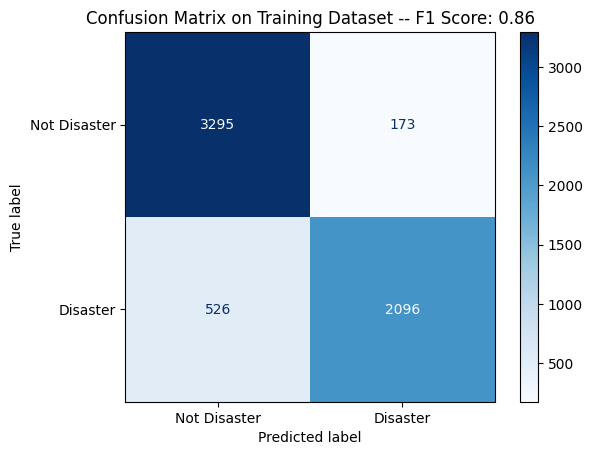

In [27]:
displayConfusionMatrix(y_train, y_pred_train, "Training")

In [28]:
y_pred_val = classifier.predict(X_val)

48/48 [==============================] - 295s 6s/step


Total: 1523.0, TP: 495.0, TN: 801.0, FP: 73.0, FN: 154.0, Prc: 0.871, Rec. 0.763, F1: 0.813


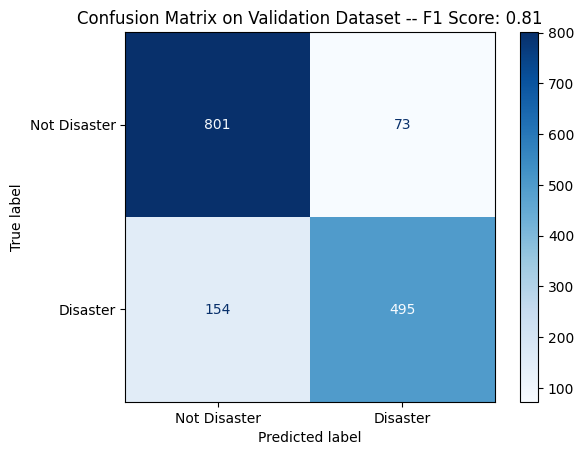

In [25]:
displayConfusionMatrix(y_val, y_pred_val, "Validation")